# Simulación del espectro registrado por un detector de NaI
By Jose Vellojin, jvellojinp@unal.edu.co

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from numpy.core.fromnumeric import mean
from scipy.stats import poisson
from pylab import text
from numpy import random
import scipy.stats as stats
import pandas as pd

# Instrucciones
* Escoger si se tendrá en cuenta el efecto de la incertidumbre en la energía dándole el valor True o False a la variable 'fuzzyness' en la siguiente celda. Tenga en cuenta que si se le asigna cualquier valor distinto a True o False, las funciones que requieran esta variable la leerán como False.
* Compilar todas las celdas en orden.


In [2]:
fuzzyness = True

#  Definiciones preliminares
* Aquí definimos funciones y constantes que usaremos en todo el código.

In [3]:
# =============================================================================
# Datos iniciales
# =============================================================================

N = 10**6 # Número de fotones
E_gamma = 662.5
mec2 = 511
eps_gamma = E_gamma/mec2
E_C = E_gamma*(2*eps_gamma/(1+2*eps_gamma)) # Borde Compton
seed = 123456789
En = np.arange(0,662.5,1)
rho = 3.67 # Densidad
mu_C = 6.54*10**(-2)*rho # Tomado de XCOM
mu_f = 8.54*10**(-3)*rho # Tomado de XCOM
mu_t   = mu_f + mu_C 
t = 7.62 # longitud detector

# =============================================================================
# Energía más pequeña que podemos considerar. Para energías más pequeñas nuestro
#  ajuste de FWHM da valores negativos.
# =============================================================================

for i in En:
    s =(-1.94+0.66*np.sqrt(i))/2.35
    if s>0:
        min_E = i
        break

# =============================================================================
# Definición de Klein-Nishina
# =============================================================================

def p(E):      
    if E<=E_C:
        eps_e = E/E_gamma
        A = eps_e**2/(eps_gamma**2*(1-eps_e)**2)
        B = (eps_e/(1-eps_e))*(eps_e-2/eps_gamma)
        return 2+ A +B
    else:
        return 0
    
# =============================================================================
# Efecto FWHM
# =============================================================================

rn.seed(seed)

def sig(E): 
    if E <min_E:  # Debajo de min_E obtendríamos valores negativos con el ajuste.
        return 0
    else:
        return (-1.94+0.66*np.sqrt(E))/2.35   # Ajuste calculado en práctica 2.

def gaussiana(E,fuzzyness):
    if fuzzyness == True:
        mu = E
        sigma = sig(E)
        
        return np.random.normal(mu, sigma, 1)
    else:
        return E

# Interactuar o no interactuar, esa es la cuestión
* Para un número N = $10^{6}$ de fotones, a través de esta rutina de Monte Carlo decidimos quienes interactuan y quienes no. El número de fotones que no interactúen se guardará en la variable 'no_interactuan' y el número de los que interactúan se guardará en 'interactuan'.

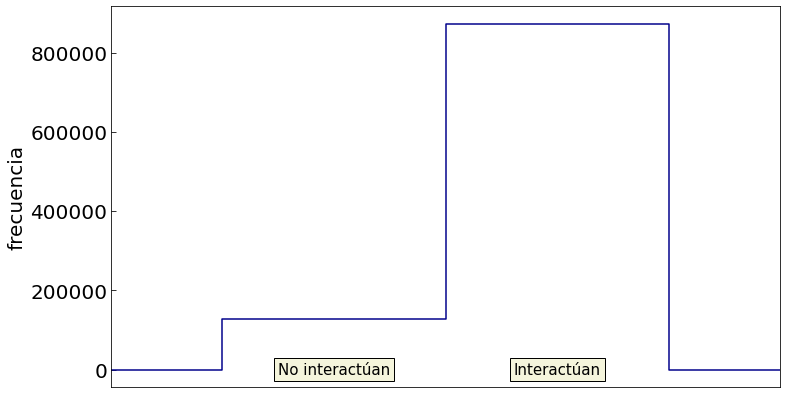

In [4]:
# =============================================================================
# Probabilidad de interacción.
# =============================================================================

rn.seed(seed)

histogram_0 = np.array([0]*4)
pdf_0 = np.array([0,np.exp(-t*mu_t),1-np.exp(-t*mu_t),0])
F_0 = np.zeros(4)
for i in range(3):
    F_0[i+1] = F_0[i]+pdf_0[i+1]


for i in range(N):

    
    r = rn.random()
    for j in range(1,3):
        if r >= F_0[j-1] and r < F_0[j]:
            bingo = j
            break
    histogram_0[bingo]+=1

no_interactuan = histogram_0[1]
interactuan = histogram_0[2]



plt.figure(figsize=(12,7))

plt.ylabel('frecuencia',alpha=1 ,fontsize = '20', color='black')
plt.xlim(0,3)
x = range(4)
plt.plot(x,histogram_0,ds='steps-mid',c="#00008B")
plt.annotate('No interactúan',(1,0), horizontalalignment='center', verticalalignment='center',bbox={"fc":"beige"},fontsize=15)
plt.annotate('Interactúan',(2,0), horizontalalignment='center', verticalalignment='center',bbox={"fc":"beige"},fontsize=15)
plt.tick_params(bottom=False,top=False,right=False,labelbottom=False,direction='in',size = 5,which='both', labelsize = '20', color='black')
#plt.savefig("interactuan.png",dpi=300)



# ¿Cómo interactuar?
* De los fotones que interactuaron (cuyo número está guardado en la variable 'interactuan') ahora debemos decidir a través de una rutina de Monte Carlo si la interacción es por Compton o efecto fotoeléctrico. En la variable 'N_C' se guardará el número de fotones que  interactúen por Compton y en 'N_f' los que lo hagan por efecto fotoeléctrico.

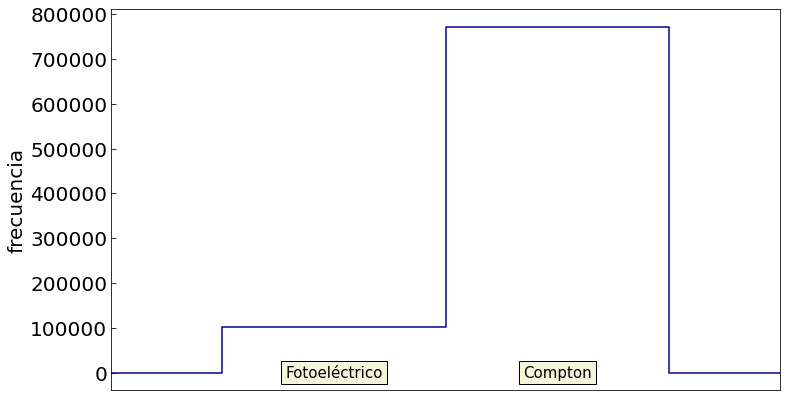

In [5]:
# =============================================================================
# ¿Fotoeléctrico o Compton?
# =============================================================================

rn.seed(seed)
p_f = mu_f/mu_t
p_C = mu_C/mu_t

histogram = np.array([0]*4)
pdf = np.array([0,p_f,p_C,0])
F = np.zeros(4)
for i in range(3):
    F[i+1] = F[i]+pdf[i+1]


for i in range(interactuan):

    
    r = rn.random()
    for j in range(1,3):
        if r >= F[j-1] and r < F[j]:
            bingo = j
            break
    histogram[bingo]+=1
    
plt.figure(figsize=(12,7))

N_f = histogram[1]
N_C = histogram[2]

plt.ylabel('frecuencia',alpha=1 ,fontsize = '20', color='black')
plt.xlim(0,3)
plt.tick_params(bottom=False,top=False,right=False,labelbottom=False,direction='in',size = 5,which='both', labelsize = '20', color='black')
plt.annotate("Fotoeléctrico",(1,0), horizontalalignment='center', verticalalignment='center',bbox={"fc":"beige"},fontsize=15)
plt.annotate("Compton",(2,0), horizontalalignment='center', verticalalignment='center',bbox={"fc":"beige"},fontsize=15)
x = range(4)
plt.plot(x,histogram,ds='steps-mid',c="#00008B")
#plt.savefig("comointeractuan.png",dpi=300)



# Para los que quisieron fotoeléctrico...
* Con los fotones que hicieron efecto fotoeléctrico (N_f de estos) formamos el fotopico. 
* Nótese como 'i_fuzzy' nos desplaza los valores de energía para reproducir la incertidumbre. Si fuzzyness es False la gráfica será una linea, si es True es una gaussiana.

(620.0, 700.0)

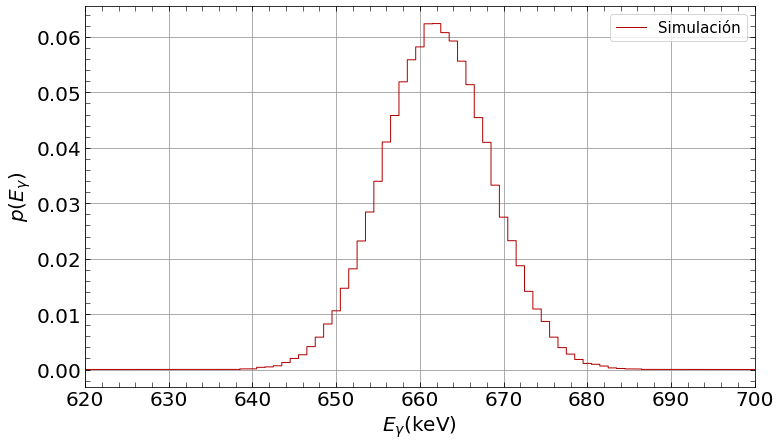

In [6]:
# =============================================================================
# Fotoeléctrico
# =============================================================================

histograma_f = [1]*800


for i in range(N_f):
    i_fuzzy = int(gaussiana(E_gamma,fuzzyness)) # Dejamos que una normal centrada en 662 nos redefina cada índice de energía. 
    histograma_f[i_fuzzy] += 1                  

plt.figure(figsize=(12,7))
plt.grid(b=True, color="#999999", linestyle="-", alpha=1)
plt.xlabel("$E_\gamma$(keV)",alpha=1 ,fontsize = '20', color='black')
plt.ylabel(r'$p(E_\gamma$)',alpha=1 ,fontsize = '20', color='black')
plt.minorticks_on()
plt.tick_params(bottom=True,top=True,right=True,direction='in',size = 5,which='both', labelsize = '20', color='black')    
plt.plot(histograma_f/N_f,lw=1,alpha=1,c=(0.7,0,0,0.9),ds='steps-mid',label="Simulación")
plt.legend(fontsize=15,loc=1)
plt.xlim(620,700)
#plt.savefig("fotopicofwhm.png",dpi=300)

# Para los que quisieron Compton...
* Con los fotones que hicieron Compton (N_C de estos) formamos la región Compton simulando por Monte Carlo la distribución de Klein-Nishina. 
* Si fuzzyness es False la simulación no mostrará valores luego del pico Compton, si es True si los muestra.

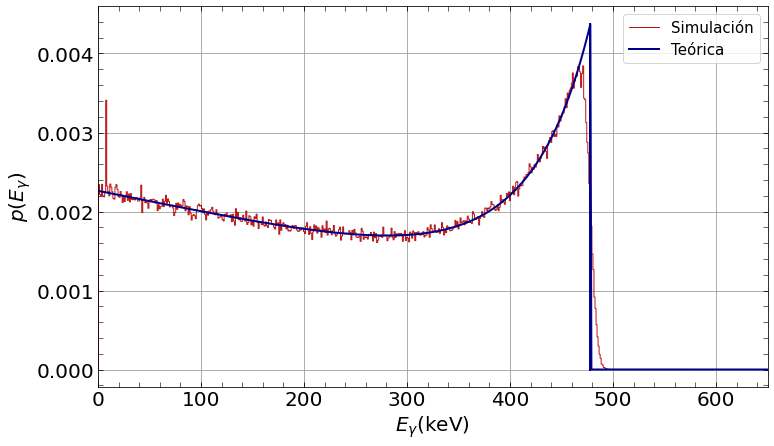

In [7]:
# =============================================================================
# Compton
# =============================================================================

rn.seed(seed)
P = [] #PDF
for i in range(len(En)):  
    P.append(p(i)) # p viene dada por Klein-Nishina. Se definió en la sección de Definiciones preliminares.
        
F = np.zeros(len(P)) #CDF
for i in range(len(P) - 1): 
    F[i+1] = F[i] + P[i+1] 
  

 
P_norm = [] #PDF normalizada
for i in range(len(P)):
    P_norm.append(P[i] / sum(P))    


histograma_C = np.zeros(len(P_norm))

F2 = np.zeros(len(P_norm)) #CDF normalizada
for i in range(len(P_norm) - 1):
    F2[i+1] = F2[i] + P_norm[i+1] 
    

    

for i in range(N_C):
    r = rn.uniform(0, 1)
    for j in range(1, len(P_norm) - 1):
        if r >= F2[j-1] and r < F2[j]:  
            bingo = j
            bingo_fuzzy = int(gaussiana(j,fuzzyness))
            histograma_C[bingo_fuzzy] += 1
            break
        
    
P_scaled = [] #PDF escalada
for i in range(len(P)):
    P_scaled.append(P_norm[i]*N) 

plt.figure(figsize=(12,7))
plt.grid(b=True, color="#999999", linestyle="-", alpha=1)
histograma_C[0] = 0.1
plt.plot(En,histograma_C/N_C,ds='steps-mid',c = (0.7,0,0,0.9),label="Simulación",lw=1)
plt.plot(En,P_norm,c="#00008B", label="Teórica",lw=2)
pmax = p(E_C)/sum(P)
plt.plot([E_C,E_C],[0,pmax],c="#00008B",lw=2)
plt.xlabel("$E_\gamma$(keV)",alpha=1 ,fontsize = '20', color='black')
plt.ylabel(r'$p(E_\gamma$)',alpha=1 ,fontsize = '20', color='black')
plt.minorticks_on()
plt.tick_params(bottom=True,top=True,right=True,direction='in',size = 5,which='both', labelsize = '20', color='black')
plt.xlim(0,650)
plt.legend(fontsize=15,loc=1)
#plt.savefig("comptonfwhm.png",dpi=300)

# Unión de espectros
* Definimos un histograma que almacenará el espectro simulado de la región Compton y del fotopico.

In [8]:
# =========================================================================================================================
# Energía más alta a la que llega Klein-Nishina simulado.
# =========================================================================================================================

for i in En:
    h = histograma_C[int(i)]
    if h==0:
        max_E = i
        break
        
# =========================================================================================================================
# Unimos los espectros
# =========================================================================================================================

histograma_supremo = []
t1 = np.arange(0,int(max_E))
t2 = np.arange(int(max_E),800)

for i in t1:
    histograma_supremo.append(histograma_C[i])
for i in t2:
    histograma_supremo.append(histograma_f[i])

# Espectro experimental 
* Subimos el espectro experimental del $^{137}$Cs medido con NaI, le restamos el fondo y luego lo reescalamos para mejor visualización.

In [9]:
f3 = pd.read_table("NaI_137Cs_600s.dat", sep="\s+")
f5 = pd.read_table("NaI_Fondo_600s.dat", sep="\s+")

x3 = -45.24+3.17*(f3['canal'].to_numpy())
y3 = f3['cuentas'].to_numpy()

x5 = -45.24+3.17*(f5['canal'].to_numpy())
y5 = f5['cuentas'].to_numpy()

y137cs = y3-y5 # restamos fondo

y137cs = y137cs/2.65 # Reescalado para comparar con simulación

# The End
* Graficamos el espectro simulado y el espectro experimental.


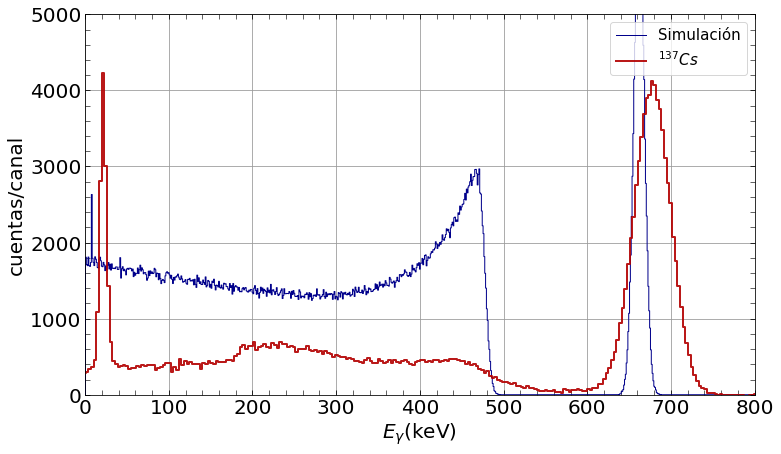

In [10]:
plt.figure(figsize=(12,7))
plt.grid(b=True, color="#999999", linestyle="-", alpha=1)
plt.plot(histograma_supremo,lw=1,alpha=1,c="#00008B",ds='steps-mid',label="Simulación")
plt.plot(x3,y137cs,drawstyle='steps-mid',linewidth=2,color=(0.7,0,0,0.9),label='$^{137}Cs$')
plt.xlabel("$E_\gamma$(keV)",alpha=1 ,fontsize = '20', color='black')
plt.ylabel('cuentas/canal',alpha=1 ,fontsize = '20', color='black')
plt.xlim(0,800)
plt.ylim(0, 5000)
plt.minorticks_on()
plt.tick_params(bottom=True,top=True,right=True,direction='in',size = 5,which='both', labelsize = '20', color='black')
plt.legend(fontsize=15,loc=1)
#plt.savefig("totalfwhm.png",dpi=300)